In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
import collections#import all the necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#connect to google drive if you are running on google colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
edgelist = "/content/drive/MyDrive/CS5683/YouTube.edgelist"
G = nx.read_edgelist(edgelist, nodetype=int)#Reading the youtube edgelist into a graph

In [ ]:
V = G.number_of_nodes()#Number of nodes in the graph
E = G.number_of_edges()#Number of edges in the graph

In [ ]:
seed_communities_path = "/content/drive/MyDrive/CS5683/20percent_seed_communities.txt"#import seed communities
seed_communities = []#reading the seed comminities into a list of list
with open(seed_communities_path) as f:
  for line in f:
    seed_communities.append([int(x) for x in line.split()])

In [ ]:
K = len(seed_communities)#Number of communities

In [ ]:
groundtruth_communities_path = "/content/drive/MyDrive/CS5683/groundtruth_communities.txt"#Import ground truth communities
groundtruth_communities = {}#reading the ground truth communities as dictionary of community as key and nodes in it as values
count = 0
with open(groundtruth_communities_path) as f:
  for line in f:
    groundtruth_communities[count] = [int(x) for x in line.split()]
    count += 1

In [ ]:
neighborhoodseeds_path = "/content/drive/MyDrive/CS5683/neighborhood_seeds.txt"#import neighborhood seed communities
neighborhood_seeds = []#reading the neighborhood seeds into a list of list as nodes in communities
with open(neighborhoodseeds_path) as f:
  for line in f:
    neighborhood_seeds.append([int(x) for x in line.split()])

Initialization using the 20% seed communities

In [ ]:
F = np.zeros((V,K))#Declaring the F matrix

In [ ]:
for i in range(len(seed_communities)):#Updating the seed communities in the F matrix using seed communities list of lists
  for j in seed_communities[i]:
    F[j][i] = 1

In [ ]:
seed_communities_nodes = np.concatenate(seed_communities)#collecting all the nodes of seed communities into a list to ignore them while calculating the conductance

In [ ]:
node_list = []#To store the updated nodes and ignore them to calculate conductance
for i in range(len(F)):#For all nodes in F
  if i not in seed_communities_nodes:#Ignore the nodes if its updated from seed communities
    if i not in node_list:#Ignore the node if its already updated as neighbor of some other node
      min_value = np.inf#To get the locally minimum community
      for j in range(len(F[0])):#For all the communities
        cond = nx.conductance(G,set(seed_communities[j]+list(G.neighbors(i))+[i]))#Call calculate the conductance by adding node and its neighbors to each of the community
        if min_value > cond:
          min_value = cond#taking the locally minimal community
          min_c = j#the community number
      for a in list(G.neighbors(i))+[i]:#update the locally minimal communities in F as 1 for node and its neighbors
        F[a][min_c] = 1
      node_list = node_list + list(G.neighbors(i))#collect already updated nodes

In [ ]:
F_store = F.copy()

In [ ]:
perc_change = 0#To calculate the percentage change
for i in range(300):#Iterating throught the optimizaation process 300 times
  sigma_allnodes = F.sum(axis=0)#Vector sum of all the nodes in the F matrix
  for u in range(len(F)):#For all the nodes in F matrix
    neighbors = list(G.neighbors(u)) #Collecting the neighbors of the node into a list
    delta1 = [0]*K #an empty list of size K to compute first part in optimization function
    sigma_v = [0]*K #An empty list to calculate vector of neighbor nodes
    for v in neighbors:#For each node in neighbors
      if (1-np.exp(-np.matmul(F[u],F[v].transpose()))): #If the denominator of the first part in the optimization function is 0 the whole value will become infinity, so checking for it and update the first part of error function appropriately
        delta1_2 = np.exp(-np.matmul(F[u],F[v].transpose()))/(1-np.exp(-np.matmul(F[u],F[v].transpose()))) # If the denominator not equal to 0
      else:
        delta1_2=0 #If denominator equal to zero
      delta1 = (F[v]*delta1_2) + delta1 #Summing the first part of the gradient function
      sigma_v = F[v] + sigma_v #Calculating vector sum of all the node neighbor as per BigClam 2.0
    delta2 = sigma_allnodes - F[u] - sigma_v #Second part of the gradient equation
    delta = delta1 - delta2 #Final gradient for a node vector
    change = 0.1*sum(delta)/sum(F[u]) #Percentage change in the vector Fu
    if change < 0.001:
      perc_change += 1
    F[u] = F[u] + 0.001*delta#Updating the vector for a node
    negative_values = F[u] < 0 # Turning the negative values to 0 in the node vector
    F[u][negative_values] = 0
  if perc_change == V:#If the percentage change for all the node vector is less that 0.001 then exiting the loop
    break

In [ ]:
threshold = np.sqrt(-np.log10(1-10e-8))#Threshold value to assign communities
assigned_communities = {} # To assign the communities and collect them into a dictionary
for i in range(len(F)): # For each row in F matrix means each node
  for j in range(len(F[0])): # For each column in F matrix
    if j not in assigned_communities.keys(): #If community is not present in the dictionary add it with empty list as value
      assigned_communities[j] = []
    if F[i][j] >= threshold:#If the Fuc value is greater than threshold then store it in the dictionary of community, list of nodes
      assigned_communities[j].append(i)#Append the community nodes

In [ ]:
file = open('/content/drive/MyDrive/CS5683/assigned_communities_20precent_seed.txt','w') #Export path for assigned communities
file.write(str("Community Number")+str("--->")+str("Nodes"))
file.write("\n")
for key,value in assigned_communities.items(): # for each item in the dictionary of assigned communities
  file.write(str(key)+str("--->")+str(value))# exporting the communities and its nodes into a text file as strings
  file.write("\n")
file.close()

In [ ]:
matched = {} # to find the store the best matched community
over = [] # To store the matched communities
for i in groundtruth_communities:#for each ground truth communities
  for j in assigned_communities: # For each assigned community
    if i not in matched.keys():#If the ground truth community
      matched[i] = (-1,0) # Initially filling the matched dictionary as ground truth community: (best matched predicted community, recall between the two)
    if matched[i][1] < len(set(assigned_communities[j])&set(groundtruth_communities[i]))/len(set(groundtruth_communities[i])): #For each ground truth I am trying to find the best matching predicted community
      if j not in over: #If a community is already assigned to a ground truth community ignore it
        matched[i] = (j,len(set(assigned_communities[j])&set(groundtruth_communities[i]))/len(set(groundtruth_communities[i])))
  over.append(matched[i][0])#collecting the assigned communities

In [ ]:
rec = 0 # Initial recall is zero
for value in matched:# As we have already stored all the ground truth communities, best match predicted community and recall between the two, we are iterating through each ground truth community and calculating total recall
  rec = rec + matched[value][1]#calculating the recall as true positive/total actual
rec = rec/K #Finally dividing with the number of communities
rec

0.30964593650427436

In [ ]:
precision = 0 # Initial precision is zero
for value in matched: # As we have already stored all the ground truth communities, best match predicted community and recall between the two
  if matched[value][0] != -1:#unassigned communities
    precision = precision + len(set(assigned_communities[matched[value][0]])&set(groundtruth_communities[value]))/len(set(assigned_communities[matched[value][0]])) #calculating the precision as true positive/total predicted
precision = precision/K # Finally dividing it with number of communities
precision

0.45740308270971447

Neighborhood seed Initialization

In [ ]:
F_n = np.zeros((V,K))

In [ ]:
for i in range(len(neighborhood_seeds)): #Updating the neighborhood seed communities in the F matrix using neighborhood seed communities list of lists
  for j in neighborhood_seeds[i]:
    F_n[j][i] = 1

In [ ]:
neighborhood_seed_nodes = np.concatenate(neighborhood_seeds)#collecting all the nodes of neighborhood seed communities into a list to ignore them while calculating the conductance

In [ ]:
node_list = []#To store the updated nodes and ignore them to calculate conductance
for i in range(len(F_n)):#For all nodes in F
  if i not in neighborhood_seed_nodes: #Ignore the nodes if its updated from neighborhood seed communities
    if i not in node_list: #Ignore the node if its already updated as neighbor of some other node
      min_value = np.inf #To get the locally minimum community
      for j in range(len(F_n[0])): #Call calculate the conductance by adding node and its neighbors to each of the community
        cond = nx.conductance(G,set(neighborhood_seeds[j]+list(G.neighbors(i))+[i]))#should we take distinct of seed community nodes and neighbor nodes
        if min_value > cond:
          min_value = cond #taking the locally minimal community
          min_c = j#the community number
      for a in list(G.neighbors(i))+[i]:#update the locally minimal communities in F as 1 for node and its neighbors
        F_n[a][min_c] = 1
      node_list = node_list + list(G.neighbors(i)) #collect already updated nodes into a list

In [ ]:
F_n_store = F_n.copy()

In [ ]:
perc_change = 0 #To calculate the percentage change
for i in range(300): #Iterating throught the optimizaation process 300 times
  sigma_allnodes = F_n.sum(axis=0) #Vector sum of all the nodes in the F matrix
  for u in range(len(F_n)): #For all the nodes in F matrix
    neighbors = list(G.neighbors(u)) #Collecting the neighbors of the node into a list
    delta1 = [0]*K #an empty list of size K to compute first part in optimization function
    sigma_v = [0]*K #An empty list to calculate vector of neighbor nodes
    for v in neighbors: #For each node in neighbors
      if (1-np.exp(-np.matmul(F_n[u],F_n[v].transpose()))): #If the denominator of the first part in the optimization function is 0 the whole value will become infinity, so checking for it and update the first part of error function appropriately
        delta1_2=np.exp(-np.matmul(F_n[u],F_n[v].transpose()))/(1-np.exp(-np.matmul(F_n[u],F_n[v].transpose()))) # If the denominator not equal to 0
      else:
        delta1_2=0 #If denominator equal to zero
      delta1 = (F_n[v]*delta1_2) + delta1 #Summing the first part of the gradient function
      sigma_v = F_n[v] + sigma_v #Calculating vector sum of all the node neighbor as per BigClam 2.0
    delta2 = sigma_allnodes - F_n[u] - sigma_v #Second part of the gradient equation
    delta = delta1 - delta2 #Final gradient for a node vector
    change = 0.1*sum(delta)/sum(F_n[u]) #Percentage change in the vector Fu
    if change < 0.001:
      perc_change += 1
    F_n[u] = F_n[u] + 0.001*delta #Updating the vector for a node
    negative_values = F_n[u] < 0 # Turning the negative values to 0 in the node vector
    F_n[u][negative_values] = 0
  if perc_change == V:#If the percentage change for all the node vector is less that 0.001 then exiting the loop
    break

In [ ]:
threshold = np.sqrt(-np.log10(1-10e-8)) #Threshold value to assign communities
assigned_communities_n = {} # To assign the communities and collect them into a dictionary
for i in range(len(F_n)): # For each row in F matrix means each node
  for j in range(len(F_n[0])): # For each column in F matrix
    if j not in assigned_communities_n.keys(): #If community is not present in the dictionary add it with empty list as value
      assigned_communities_n[j] = []
    if F_n[i][j] >= threshold: #If the Fuc value is greater than threshold then store it in the dictionary of community, list of nodes
      assigned_communities_n[j].append(i) #Append the community nodes

In [ ]:
file_n = open('/content/drive/MyDrive/CS5683/assigned_communities_neighborhood_seed.txt','w') #Export path for assigned communities
file_n.write(str("Community Number")+str("--->")+str("Nodes"))
file_n.write("\n")
for key,value in assigned_communities_n.items(): # for each item in the dictionary of assigned communities
  file_n.write(str(key)+str("--->")+str(value)) # exporting the communities and its nodes into a text file as strings
  file_n.write("\n")
file_n.close()

In [ ]:
matched_n = {} # to find the store the best matched community
over = [] # To store the matched communities
for i in groundtruth_communities: #for each ground truth communities
  for j in assigned_communities_n: # For each assigned community
    if i not in matched_n.keys(): #If the ground truth community
      matched_n[i] = (-1,0) # Initially filling the matched dictionary as ground truth community: (best matched predicted community, recall between the two)
    if matched_n[i][1] < len(set(assigned_communities_n[j])&set(groundtruth_communities[i]))/len(set(groundtruth_communities[i])): #For each ground truth I am trying to find the best matching predicted community
      if j not in over: #If a community is already assigned to a ground truth community ignore it
        matched_n[i] = (j,len(set(assigned_communities_n[j])&set(groundtruth_communities[i]))/len(set(groundtruth_communities[i])))
  over.append(matched_n[i][0]) #collecting the assigned communities

In [ ]:
rec_n = 0 # Initial recall is zero
for value in matched_n: # As we have already stored all the ground truth communities, best match predicted community and recall between the two, we are iterating through each ground truth community and calculating total recall
  rec_n = rec_n + matched_n[value][1] #calculating the recall as true positive/total actual
rec_n = rec_n/K #Finally dividing with the number of communities
rec_n

0.040700161321320746

In [ ]:
precision_n = 0 # Initial precision is zero
for value in matched_n: # As we have already stored all the ground truth communities, best match predicted community and recall between the two
  if matched_n[value][0] != -1: #unassigned communities
    precision_n = precision_n + len(set(assigned_communities_n[matched_n[value][0]])&set(groundtruth_communities[value]))/len(set(assigned_communities_n[matched_n[value][0]])) #calculating the precision as true positive/total predicted
precision_n = precision_n/K # Finally dividing it with number of communities
precision_n

0.4053304363749031

Random number initialization

In [ ]:
F_r = np.random.rand(V,K) # Creating a simple factor matrix with random values in range between [0,1]

In [ ]:
perc_change = 0 #To calculate the percentage change
for i in range(300): #Iterating throught the optimizaation process 300 times
  sigma_allnodes = F_r.sum(axis=0) #Vector sum of all the nodes in the F matrix
  for u in range(len(F_r)): #For all the nodes in F matrix
    neighbors = list(G.neighbors(u)) #Collecting the neighbors of the node into a list
    delta1 = [0]*K #an empty list of size K to compute first part in optimization function
    sigma_v = [0]*K #An empty list to calculate vector of neighbor nodes
    for v in neighbors: #For each node in neighbors
      if (1-np.exp(-np.matmul(F_r[u],F_r[v].transpose()))): #If the denominator of the first part in the optimization function is 0 the whole value will become infinity, so checking for it and update the first part of error function appropriately
        delta1_2=np.exp(-np.matmul(F_r[u],F_r[v].transpose()))/(1-np.exp(-np.matmul(F_r[u],F_r[v].transpose()))) # If the denominator not equal to 0
      else:
        delta1_2=0 #If denominator equal to zero
      delta1 = (F_r[v]*delta1_2) + delta1 #Summing the first part of the gradient function
      sigma_v = F_r[v] + sigma_v #Calculating vector sum of all the node neighbor as per BigClam 2.0
    delta2 = sigma_allnodes - F_r[u] - sigma_v #Second part of the gradient equation
    #print(delta2)
    #print(delta1)
    delta = delta1 - delta2 #Final gradient for a node vector
    change = 0.01*sum(delta)/sum(F_r[u]) #Percentage change in the vector Fu
    if abs(change) < 0.001:
      perc_change += 1
    F_r[u] = F_r[u] + 0.0001*delta #Updating the vector for a node
    negative_values = F_r[u] < 0 # Turning the negative values to 0 in the node vector
    F_r[u][negative_values] = 0
  if perc_change == V: #If the percentage change for all the node vector is less that 0.001 then exiting the loop
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
threshold = np.sqrt(-np.log10(1-10e-8)) #Threshold value to assign communities
assigned_communities_r = {} # To assign the communities and collect them into a dictionary
for i in range(len(F_r)): # For each row in F matrix means each node
  for j in range(len(F_r[0])): # For each column in F matrix
    if j not in assigned_communities_r.keys(): #If community is not present in the dictionary add it with empty list as value
      assigned_communities_r[j] = []
    if F_r[i][j] >= threshold: #If the Fuc value is greater than threshold then store it in the dictionary of community, list of nodes
      assigned_communities_r[j].append(i) #Append the community nodes

In [ ]:
file_r = open('/content/drive/MyDrive/CS5683/assigned_communities_random.txt','w') #Exporting the assigned or predicted communites as communites and its nodes into a text file
file_r.write(str("Community Number")+str("--->")+str("Nodes"))
file_r.write("\n")
for key,value in assigned_communities_r.items():
  file_r.write(str(key)+str("--->")+str(value))
  file_r.write("\n")
file_r.close()

In [ ]:
matched_r = {} # to find the store the best matched community
over = [] # To store the matched communities
for i in groundtruth_communities: #for each ground truth communities
  for j in assigned_communities_r: # For each assigned community
    if i not in matched_r.keys(): #If the ground truth community
      matched_r[i] = (-1,0) # Initially filling the matched dictionary as ground truth community: (best matched predicted community, recall between the two)
    if matched_r[i][1] < len(set(assigned_communities_r[j])&set(groundtruth_communities[i]))/len(set(groundtruth_communities[i])): #For each ground truth I am trying to find the best matching predicted community
      if j not in over: #If a community is already assigned to a ground truth community ignore it
        matched_r[i] = (j,len(set(assigned_communities_r[j])&set(groundtruth_communities[j]))/len(set(groundtruth_communities[i])))
  over.append(matched_r[i][0]) #collecting the assigned communities

In [ ]:
rec_r = 0 # Initial recall is zero
for value in matched_r: # As we have already stored all the ground truth communities, best match predicted community and recall between the two, we are iterating through each ground truth community and calculating total recall
  rec_r = rec_r + matched_r[value][1] #calculating the recall as true positive/total actual
rec_r = rec_r/K #Finally dividing with the number of communities
rec_r 

0.005488982807004632

In [ ]:
precision_r = 0 # Initial precision is zero
for value in matched_r: # As we have already stored all the ground truth communities, best match predicted community and recall between the two
  if matched_r[value][0] != -1: #unassigned communities
    precision_r = precision_r + len(set(assigned_communities_r[matched_r[value][0]])&set(groundtruth_communities[value]))/len(set(assigned_communities_r[matched_r[value][0]])) #calculating the precision as true positive/total predicted
precision_r = precision_r/K # Finally dividing it with number of communities
precision_r

0.11747301042432888

Comparing plots

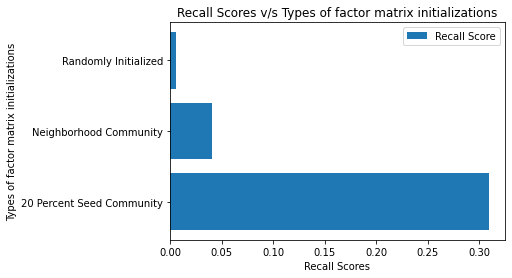

In [ ]:
import matplotlib.pyplot as plt
plt.barh(["20 Percent Seed Community","Neighborhood Community","Randomly Initialized"],[rec,rec_n,rec_r], align='center', label="Recall Score")
plt.legend()
plt.ylabel('Types of factor matrix initializations')
plt.xlabel('Recall Scores')
plt.title('Recall Scores v/s Types of factor matrix initializations')
plt.show()

The above shows the comparision plot of recall for all the three initialization methods. Recall means the true positive by total actual. Recall is the estimated probability that a document randomly selected from the pool of relevant documents is retrieved. The first initialization which is 20% seed communities initilization seems to be the best

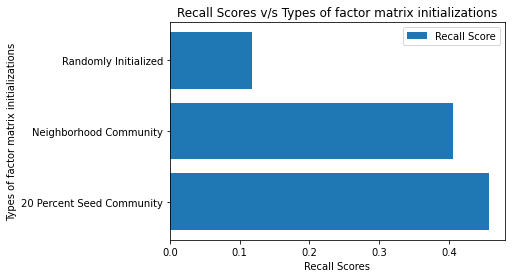

In [ ]:
import matplotlib.pyplot as plt
plt.barh(["20 Percent Seed Community","Neighborhood Community","Randomly Initialized"],[precision,precision_n,precision_r], align='center', label="Recall Score")
plt.legend()
plt.ylabel('Types of factor matrix initializations')
plt.xlabel('Recall Scores')
plt.title('Recall Scores v/s Types of factor matrix initializations')
plt.show()

The above shows the comparision plot of precision for all the three initialization methods. Precision means the true positive by total predicted.  Precision is the estimated probability that a document randomly selected from the pool of retrieved documents is relevant. The first initialization which is 20% seed communities initilization seems to be the best